In [1]:
# Load the python package
import os
# import dynetan
from dynetan.toolkit import *
from dynetan.viz import *
from dynetan.proctraj import *
from dynetan.gencor import *
from dynetan.contact import *
from dynetan.datastorage import *

#from numpy.linalg import norm
from itertools import islice
from scipy import stats

import pandas as pd
import numpy as np
import scipy as sp

In [2]:
dnad = DNAdata()

# Load network data obtained by Dynetan module 

In [17]:
dataDir = "/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_NMR_Cas9Muts/Hypa_0MM/Network_Analysis/4rep"

# Path where results will be written (you may want plots and data files in a new location)
workDir = "/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_NMR_Cas9Muts/Hypa_0MM/Network_Analysis/4rep"

fileNameRoot = "Hypa0MM_network" ## from first notebook output
fullPathRoot = os.path.join(dataDir, fileNameRoot)

# Define the segID of the Ligand being studied.
ligandSegID = "SYST"
dnad.loadFromFile(fullPathRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"

workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# We add this to the object for ease of access.
dnad.nodesAtmSel = workUviz.atoms[ dnad.nodesIxArray ]
print(dnad.nodesAtmSel)

atomToNode int64 (26254,) 26254
contactMat int64 (1482, 1482) 2196324
contactNodesInter int64 (0,) 0
corrMatAll float64 (1, 1482, 1482) 2196324
distsAll float64 (1, 1482, 1482) 2196324
interNodePairs int64 (0,) 0
maxDirectDist float64 () 1
maxDist float64 () 1
nodeDists float64 (4, 1097421) 4389684
nodesIxArray int64 (1482,) 1482
numNodes int32 () 1
<AtomGroup [<Atom 5: CA of type C of resname LYS, resid 1 and segid SYST and altLoc >, <Atom 27: CA of type C of resname TYR, resid 2 and segid SYST and altLoc >, <Atom 48: CA of type C of resname SER, resid 3 and segid SYST and altLoc >, ..., <Atom 26188: P of type P of resname DT, resid 1480 and segid SYST and altLoc >, <Atom 26220: P of type P of resname DG3, resid 1481 and segid SYST and altLoc >, <Atom 26254: Mg+ of type MG of resname Mg+, resid 1482 and segid SYST and altLoc >]>


A function to calculate pathlengths in terms of edge betweenness:

In [18]:
def getBCsum(List, Indx):
        bc = 0
        # Iterate over edges in the path
        for i in range(len(List)-1):
            node1 = List[i]
            node2 = List[i+1]
            if node1 > node2:
                btw = (dnad.btws[Indx][( node2, node1)])/maximumBetweeness
            else:
                btw = (dnad.btws[Indx][( node1, node2)])/maximumBetweeness
            bc += btw
        return bc

## write down the opt- and sub-opt paths between source and sink:

In [92]:
source = list(range(1187,1191)) ## ## resid list
sink = [1047, 1052, 471, 476] ## resid list

# Initialize variable with high value.
minimumBetweeness = 100
# Initialize variable with low value.
maximumBetweeness = -1

for pair,btw in dnad.btws[0].items():
    if btw < minimumBetweeness:
            minimumBetweeness = btw
    if btw > maximumBetweeness:
            maximumBetweeness = btw

# Normalize the value.
minimumBetweeness /= maximumBetweeness
# Determine how many extra sub-optimal paths will be written.
numSuboptimalPaths = 5   


pathListFileD = open(os.path.join(workDir, "switchTocatres_allpaths_tgR973A.dat"), "w")

for srcNode in source:
    print(srcNode)
    for trgNode in sink:

        tmpList = getSelFromNode(srcNode,dnad.nodesAtmSel, atom=True).split()
        srcNodeSel = "".join([tmpList[1],tmpList[4],tmpList[10]])

        tmpList = getSelFromNode(trgNode,dnad.nodesAtmSel, atom=True).split()
        trgNodeSel = "".join([tmpList[1],tmpList[4],tmpList[10]])

        for winIndx in range(dnad.numWinds):
            
            normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
            normCorMat /= normCorMat.max()
            
            allPaths = []
            
            # Reconstructs the optimal path from Floyd-Warshall algorithm
            pathFW = nx.reconstruct_path(srcNode, trgNode, dnad.preds[winIndx])
            allPaths.append(pathFW)

#             Behind the scenes, use Dijkstra algorithm to find sub-optimal paths
            for pathSO in islice(nx.shortest_simple_paths(dnad.nxGraphs[0], 
                                                srcNode, trgNode, weight="dist"), 1, numSuboptimalPaths + 1):
                allPaths.append(pathSO)
    
                    
            ### ---- Write all the paths calculated so far ---- ####      
            
         # Create a counter of number of paths that go though each edge, among all (sub-)optimal path(s).
            pathCounter = defaultdict(int)
            for pathIndx, pathIter in enumerate(allPaths):
                # Iterate over edges in the path
                for i in range(len(pathIter)-1):

                    node1 = pathIter[i]
                    node2 = pathIter[i+1]

                    pathCounter[(node1, node2)] += 1
#                 print(pathCounter)

            # Normalize the count
            maxCount = np.max(list(pathCounter.values()))
            for pair, count in pathCounter.items():
                pathCounter[pair] = count/maxCount

            for pathIndx, pathIter in enumerate(allPaths):
            # Iterate over edges in the path
                for i in range(len(pathIter)-1):

                    node1 = pathIter[i] + 1
                    node2 = pathIter[i+1] + 1

                     # Get the betweeness value
                    try:
                        if node1 > node2:
                            btw = (dnad.btws[winIndx][( node2, node1)])
                        else:
                            btw = (dnad.btws[winIndx][( node1, node2)])
                    except:
                        # If one could not be calculated (very few paths going though this edge)
                         # set an arbitrarily low value.
                        btw = minimumBetweeness


                    string = "{} {} {} {} {} {}".format(node1, node2, 
                                                         normCorMat[ node1, node2], 
                                                         btw/maximumBetweeness, pathCounter[(node1, node2)], 
                                                         pathIndx)

                    pathListFileD.write( string + "\n" )

pathListFileD.close()

1187
1188
1189
1190


## Calculate occurance of nodes across optimal and Sub-optimal pathways

In [86]:
s1 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA-muts/switchTocatres_allpaths_tgR973A.dat')
print(s1.shape)
print(s1.shape[0])

(1084, 6)
1084


Occurence of residues in top-ranked paths:

In [87]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return unique_list
tg_source_sink = [1048, 1053, 477, 472, 1187, 1188, 1189, 1190] # List of resids of sources and sinks
path_ranks = [0, 1, 2, 3] # ranks of paths
with open('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA-muts/switchTocatres_tgR973A_nodefreq.dat', 'w') as h:
    resid1 = []
    for i in list(range(s1.shape[0])):
        if s1[i,5] in path_ranks:
            resid1.append(int(s1[i,1]))
    print("shape of residue list:", len(resid1))
    print("No of unique residues in the list:", len(unique(resid1)))
    print("Unique residues are:", unique(resid1))
    for x in unique(resid1):
        if x not in tg_source_sink: ## Excluding the source and sink resids
#             if int(resid1.count(x)) > 10: ## filter only those residues with ocuurance > 10
            print(x, int(resid1.count(x)), file=h)


shape of residue list: 704
No of unique residues in the list: 26
Unique residues are: [1048, 1049, 1051, 1180, 1053, 1181, 1054, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 962, 963, 964, 965, 967, 968, 969, 471, 472, 473, 475, 477]


In [88]:
! sort -n -k1 /Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA-muts/switchTocatres_tgR973A_nodefreq.dat > /Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA-muts/switchTocatres_tgR973A_nodefreq_sorted.dat
# ! sort -n -k1 /Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/switchToCatres_nodefreq.dat > /Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/switchToCatres_nodefreq_sorted.dat

In [89]:
s2_tg = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA-muts/switchTocatres_tgR973A_nodefreq_sorted.dat')
# s2_tg = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/switchToCatres_nodefreq_sorted.dat')

In [90]:
resid = []
for i in list(range(s2_tg.shape[0])):
        resid.append(str(s2_tg[i,0]))
count = []
for i in list(range(s2_tg.shape[0])):
        count.append((s2_tg[i,1]))

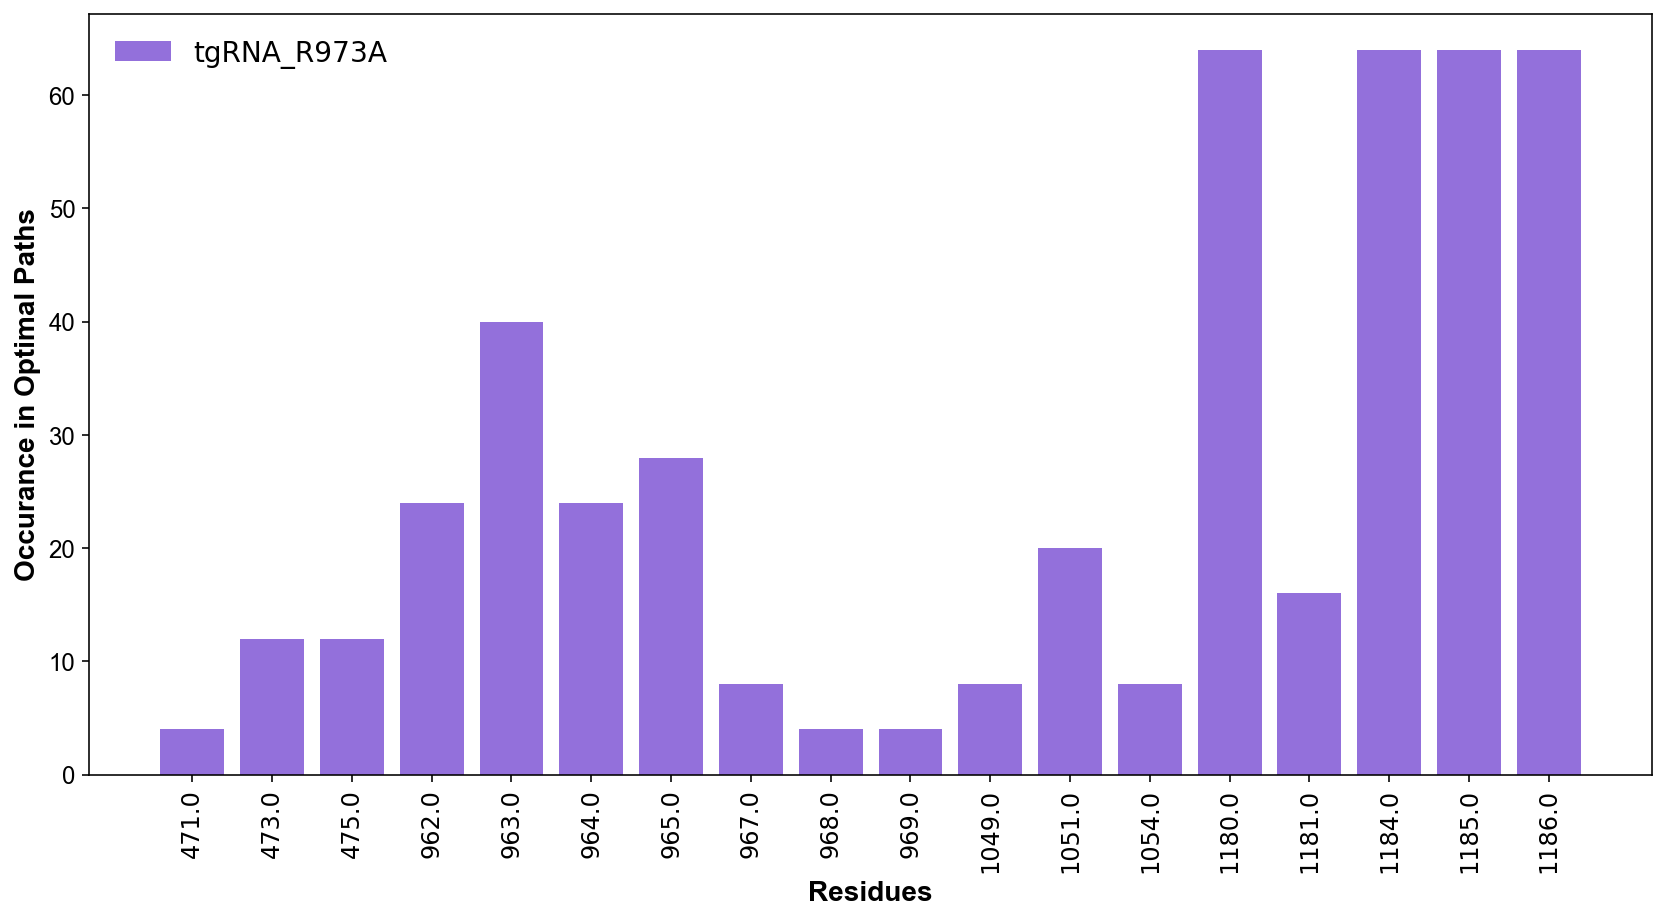

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
## Plotting
%matplotlib inline

plt.figure(figsize=(14,7))
plt.bar(resid, count, color ='mediumpurple',width = 0.8, label='tgRNA_R973A')

# plt.axis([1153, 1200, -0.4, 0.4])

plt.xlabel("Residues", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.ylabel("Occurance in Optimal Paths", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.yticks(fontname = 'Arial', fontsize ='large')
plt.xticks(
    rotation=90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='large'  
)
plt.legend(prop={"size":14}, frameon=False)
plt.savefig("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA-muts/switchTocatres_tgR973A_nodefreq.png", dpi=600)

## Calculate path-length across all optimal and sub-optimal pathways between pair of source-sink

In [ ]:
import numpy as np
s1 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/switchToCatres_allpaths.dat')
s2 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA/switchToCatres_allpaths.dat')
s3 = np.loadtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA/run/Network_Analysis/crRNA/switchToCatres_allpaths.dat')

d = 0
c = 0
pathlengths_tg = []
pathcount_tg = []
subpathID = [0, 1, 2, 3, 4, 5] ## if want to get lengths of only the optimal path, subpathID = [0]
for j in subpathID:
    for i in list(range(s2.shape[0])):
        if (s2[i,5] == j):
            d += s2[i,3]
            c += 1
        elif d != 0:
                pathlengths_tg.append(d)
                pathcount_tg.append(c)
                d = 0
                c = 0
        else:
            d = 0
            c = 0
print("shape of pathlengths list:", len(pathlengths_tg))
print("Path lengths:", pathcount_tg)
print("Average path length (betweenness estimate, pathlength estimate):", (sum(pathlengths_tg) / len(pathlengths_tg)), (sum(pathcount_tg) / len(pathcount_tg)) )

d = 0
c = 0
pathlengths_atg = []
pathcount_atg = []
for j in subpathID:
    for i in list(range(s1.shape[0])):
        if (s1[i,5] == j):
            d += s1[i,3]
            c += 1
        elif d != 0:
                pathlengths_atg.append(d)
                pathcount_atg.append(c)
                d = 0
                c = 0
        else:
            d = 0
            c = 0
print("shape of pathlengths list:", len(pathlengths_atg))
print("Path lengths:", pathcount_atg)
print("Average path length (betweenness estimate, pathlength estimate):", (sum(pathlengths_atg) / len(pathlengths_atg)), (sum(pathcount_atg) / len(pathcount_atg)))

d = 0
c = 0
pathlengths_cr = []
pathcount_cr = []
for j in subpathID:
    for i in list(range(s3.shape[0])):
        if (s3[i,5] == j):
            d += s3[i,3]
            c += 1
        elif d != 0:
                pathlengths_cr.append(d)
                pathcount_cr.append(c)
                d = 0
                c = 0
        else:
            d = 0
            c = 0

print("shape of pathlengths list:", len(pathlengths_cr))
print("Path lengths:", pathcount_cr)
print("Average path length (betweenness estimate, pathlength estimate):", (sum(pathlengths_cr) / len(pathlengths_cr)), (sum(pathcount_cr) / len(pathcount_cr)))


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
## Plotting
%matplotlib inline
fig = plt.figure(figsize=(8,6))

import seaborn as sb
ax = sb.kdeplot(pathcount_cr, color="springgreen", shade=True, alpha=0.5, linewidth=1, label = 'crRNA')
ax = sb.kdeplot(pathcount_tg, color="mediumpurple", shade=True, alpha=0.5, linewidth=1, label = 'tgRNA')
ax = sb.kdeplot(pathcount_atg, color="lightcoral", shade=True, alpha=0.5, linewidth=1, label = 'atgRNA')
# ax = sb.kdeplot(pathlengths_cr, color="springgreen", shade=True, alpha=0.5, linewidth=1, label = 'crRNA')
# ax = sb.kdeplot(pathlengths_tg, color="mediumpurple", shade=True, alpha=0.5, linewidth=1, label = 'tgRNA')
# ax = sb.kdeplot(pathlengths_atg, color="lightcoral", shade=True, alpha=0.5, linewidth=1, label = 'atgRNA')

#Setting the border of the box
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
# plt.xlim(-2, 6)
# plt.ylim(0, 0.35)


plt.xlabel("Opt Path length", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.ylabel("Density", fontname = 'Arial', fontsize = 14, fontweight = 'bold')
plt.xticks(fontname = 'Arial', fontsize = 12)
plt.yticks(fontname = 'Arial', fontsize = 12)
plt.legend(prop={"size":14}, loc = "upper right",frameon=False)
# plt.legend(prop={"size":14}, frameon=False)
plt.tight_layout()
# plt.savefig("/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA-target/run/Network_Analysis/tgRNA/seedToCatres_SubOptPathLength_btw.png", dpi=600)

## Calculate inter-domain betweennesses which is a more robust data than intercommunity betweenness data. 

In [19]:

# a function to assign nodes to a specific domain
def search(lst, value):
    for i in range(len(lst)):
        if value in lst[i]:
            return i

# define a list of domain residue ranges
domain = [list(range(167,307)), list(range(494, 710)), list(range(710, 762))+list(range(906, 1096)), list(range(762, 906)), list(range(1451, 1470)), list(range(1362, 1381))] 
# create a 2d np.array to fill domain betweenness
domain_bet = np.zeros(shape=(len(domain), len(domain)))
# print(search(domain_1, 1214))
for winIndx in range(dnad.numWinds):
    
    normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
    normCorMat /= normCorMat.max()

    for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
       ## A running matrix to fill out domain betweenness
        running_dom = np.zeros(shape=(len(domain), len(domain)))
        node1 = pair[0]
        node2 = pair[1]

      # if the nodes doesn't belong to the same domain, calculate the betweenness between them
        if (node1 < 1470) and (node2 < 1470):
            if search(domain,node1) != search(domain,node2):
                running_dom[search(domain,node1), search(domain,node2)] = normCorMat[ node1, node2]
                running_dom[search(domain,node2), search(domain,node1)] = normCorMat[ node1, node2]
                domain_bet = np.add(domain_bet, running_dom) # updating after each frame

print(domain_bet)
domain_bet_round = np.round_(domain_bet, decimals = 3)
np.save(os.path.join(workDir, "Hypa_4rep_InterDomain_betweenness.npy"), domain_bet_round)
np.savetxt(os.path.join(workDir, "Hypa_4rep_InterDomain_betweenness.csv"), domain_bet_round, fmt='%.3f', delimiter=",")


[[ 30.06506171  34.08581986  30.06506171  33.52567898  30.06506171
   30.06506171]
 [ 23.07004129  19.04928314  21.74661218  19.04928314  26.7280739
   29.82354577]
 [182.66870794 185.36603698 182.66870794 207.83747504 191.90114855
  187.57841774]
 [  6.26621677   2.8055995   27.97436659   2.8055995   11.66520217
   14.84035909]
 [ 12.87893008  20.55772084  22.11137068  21.73853274  12.87893008
   47.11921156]
 [ 46.63223254  57.40649517  51.54194233  58.66699212  80.87251402
   46.63223254]]


# This section reads the interdomain betweenness matrices and calculate the difference in interdomain betweennesses of 2 comparable systems...

In [ ]:
from numpy import genfromtxt
s1 = genfromtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-crRNA/run/Network_Analysis/crRNA/crRNA_networkData_InterDomain_betweenness.csv', delimiter=',')
s2 = genfromtxt('/Users/souviksinha/Desktop/Palermo_Lab/LabWork/Project_Cas13a/LbuCas13a-Antitag/run/Network_Analysis/atgRNA/atgRNA_withoutTGRNA_networkData_InterDomain_betweenness.csv', delimiter=',')
# print(s1)
print(s1.shape[0], s1.shape[1])

In [ ]:
## differential domain betweenness #######
import numpy as np
t1 =  np.zeros(shape=(s1.shape[0], s1.shape[1]))

for i in range(s1.shape[0]):
    for j in range(s1.shape[1]):
        t1[i,j] = s1[i,j] - s2[i,j]
# t1 = s1 -s2
print(s1)
print(s2)
print(t1)
np.savetxt("tgRNA/crRNA-atgRNA_InterDomain_betweenness.csv", t1, fmt='%.3f', delimiter=",")

## For read graph and visulaize network

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
interdomain_bet = np.genfromtxt("tgRNA/tgRNA-atgRNA_withTGRNA_InterDomain_betweenness.csv", delimiter=",")


print(interdomain_bet)
print(interdomain_bet.shape)

In [ ]:
b = np.triu(interdomain_bet)
print(b)

In [ ]:
node_names = ['NTD', 'Helical-1', 'HEPN1-I', 'Helical-2', 'HEPN1-II', 'Linker', 'HEPN2', 'crRNA']

In [ ]:
import matplotlib.pyplot as plt
# %matplotlib inline
# fig, ax = plt.subplots()
# ig.plot(g, target=ax)
import igraph as ig 
from igraph import *

# get the row, col indices of the non-zero elements in your adjacency matrix
conn_indices = np.where(b)

# get the weights corresponding to these indices
weights = b[conn_indices]

# a sequence of (i, j) tuples, each corresponding to an edge from i -> j
edges = zip(*conn_indices)

# initialize the graph from the edge sequence
G = ig.Graph(edges=edges, directed=False)

color_list = []
for i in weights:
    if i < 0:
        color_list.append('red')
    else:
        color_list.append('cyan')
# assign node names and weights to be attributes of the vertices and edges
# respectively
G.vs['label'] = node_names
G.es['color'] = color_list
G.es['weight'] = np.absolute(weights)

# G.es['color'] = color_list

# I will also assign the weights to the 'width' attribute of the edges. this
# means that igraph.plot will set the line thicknesses according to the edge
# weights
G.es['width'] = np.absolute(weights)



# plot the graph, just for fun
# igraph.plot(G, layout="rt", labels=True, margin=80, target=ax)
layout = G.layout("circle")
visual_style = {}
visual_style["vertex_size"] = 70
visual_style["vertex_color"] = "wheat"
visual_style["labels"] = True
visual_style["margin"] = 80
visual_style["layout"] = layout

# ig.plot(G, vertex_size=70, vertex_color="wheat", layout=layout, labels=True, margin=80)
ig.plot(G,"tgRNA/crRNA_networkData_InterDomain_betweenness.png", **visual_style)